`2024-03-03`

In [1]:
using PyPlot
using FFTW
using LsqFit
using Statistics
using MAT
using JLD2
using DSP
    # myNum = 3
    # myNumA = myNum*2 + 1
    # hammingW = DSP.Windows.hamming(myNumA);

In [2]:
function qft(inputdata)
    dims = (1,2);
    outputdata = fftshift(fft(fftshift(inputdata,dims),dims),dims);
    return outputdata
end

function qift(inputdata)
    dims = (1,2);
    outputdata = ifftshift(ifft(ifftshift(inputdata,dims),dims),dims);
    return outputdata
end


function rmsCombineDataCoils(inputdata)
    szl = ndims(inputdata)
    t = size(inputdata,szl)
    if szl == 2
        outputdata = inputdata;
    end
    if szl > 2
        outputdata = sqrt.(sum(abs.(inputdata).^2,dims=szl)/t);
    end
    return outputdata
end

function imal(inputdata, displayHorizontalNumber, displayVerticalNumber)
    szl = ndims(inputdata)
    if (szl == 3) && (typeof(inputdata[1]) <: Real)
        sz1,sz2,sz3 = size(inputdata)
        if displayHorizontalNumber*displayVerticalNumber <= sz3
            inputdata2 = inputdata[:,:,1:displayHorizontalNumber*displayVerticalNumber]
        else   
            inputdata2 = zeros(typeof(inputdata[1]), sz1,sz2, displayHorizontalNumber*displayVerticalNumber)
            inputdata2[:,:,1:sz3] = inputdata
        end
        inputdata2 = reshape(inputdata2, (sz1,sz2*displayHorizontalNumber, displayVerticalNumber))
        showme = inputdata2[:,:,1]
        for count = 2:displayVerticalNumber
            showme = vcat(showme,inputdata2[:,:,count])
        end
        print(sizeof(showme))
        imshow(showme,cmap="gray",interpolation = "none")
    else
        error("Input data of imal function should be a 3D image of real values")

    end
end

imal (generic function with 1 method)

### loading data

In [3]:
filename1 = joinpath("./","sl_21_85_149.mat")
vars = matread(filename1)
data=vars["data"];

In [4]:
@show xdim,ydim,zdim,coildim=size(data)
anatomy = rmsCombineDataCoils(data);

(xdim, ydim, zdim, coildim) = size(data) = (192, 192, 3, 32)


884736

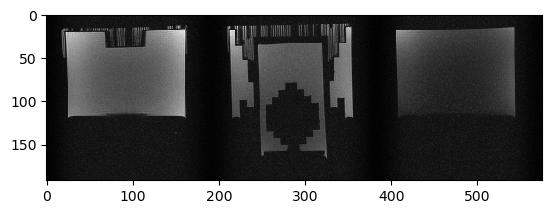

In [5]:
imal(anatomy[:,:,:,1],3,1);

### smoothing images

884736

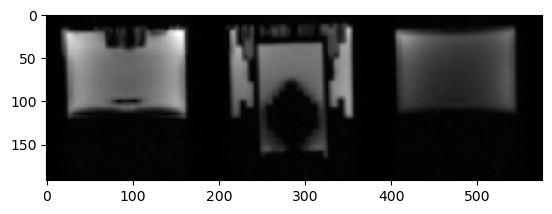

In [6]:
i = complex(0,1);
k = qift(data);

myDIM = 64;
kernel1Dx = zeros(xdim);
kernel1Dx[div(xdim,2)-(div(myDIM,2)-1):div(xdim,2)+div(myDIM,2)] = DSP.Windows.hamming(myDIM);
kernel1Dy = zeros(ydim);
kernel1Dy[div(ydim,2)-(div(myDIM,2)-1):div(ydim,2)+div(myDIM,2)] = DSP.Windows.hamming(myDIM);
kernel2D = kernel1Dx * transpose(kernel1Dy);

k_smoothed = k *0;

for cntc = 1:coildim
    for cntz = 1:zdim
        k_smoothed[:,:,cntz,cntc] = k[:,:,cntz,cntc].* kernel2D;
    end
end

data_smoothed = qft(k_smoothed);

anatomy_smoothed = rmsCombineDataCoils(data_smoothed);

imal(anatomy_smoothed[:,:,:,1],3,1);


### computing coil sensitivity profiles

In [7]:
coil_s_profiles = data_smoothed ./ repeat(anatomy_smoothed,1,1,1,coildim);

In [8]:
mask = anatomy_smoothed .> 0.1*maximum(anatomy_smoothed[:]);

In [9]:
# meshgrid of x-y-coordinates for all the voxels in 2D FOV
xcoordinate = range(1,xdim); 
xcoordinate = repeat(xcoordinate,1,ydim);
ycoordinate = range(1,ydim)';
ycoordinate = repeat(ycoordinate,xdim,1);
xy = hcat(xcoordinate[:], ycoordinate[:]);

In [10]:
# Biot-Savart equation
function Biot_Savart(xy, p)
    a,b,c,d = p
    x = xy[:, 1]
    y = xy[:, 2]
    g = a ./ ((x.-b).^2 + (y.-c).^2 .+ d.^2)
    return g[:]
end


Biot_Savart (generic function with 1 method)

In [11]:
coil_s_profiles_fitted = coil_s_profiles .* 0;
for choose_this_slice = 1: zdim
    m = mask[:,:, choose_this_slice];
    xcoordinate_masked = xcoordinate[m.>0]
    ycoordinate_masked = ycoordinate[m.>0]
    xy_masked = hcat(xcoordinate_masked[:], ycoordinate_masked[:]);
    for cnt = 1:coildim
        s = abs.(coil_s_profiles[:,:,choose_this_slice, cnt])
        s_masked = s[m.>0];
        p0 = Float64.([10, 10, 10, 10])
        fit = curve_fit(Biot_Savart, xy_masked, s_masked,p0)
        updatedP =  fit.param;
        fitted_map = Biot_Savart(xy,updatedP);
        fitted_map2D = reshape(fitted_map,xdim,ydim);
        coil_s_profiles_fitted[:,:,choose_this_slice, cnt] = fitted_map2D;
    end
end

In [12]:
coil_s_profiles_fitted = coil_s_profiles_fitted .* exp.(i.*angle.(coil_s_profiles));

943718494371849437184

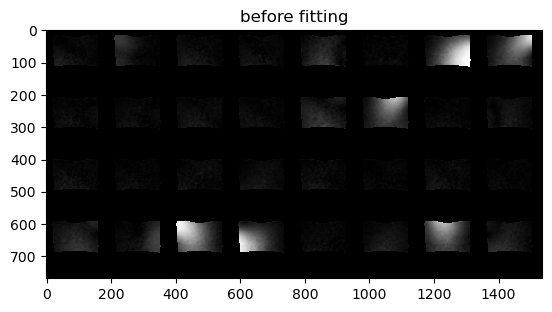

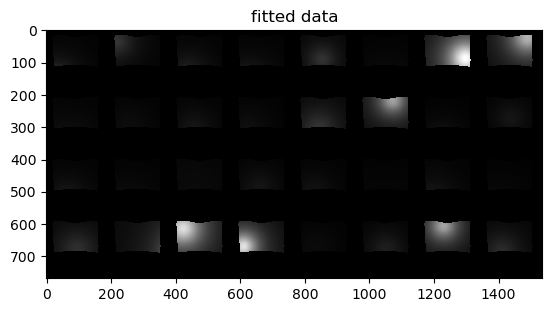

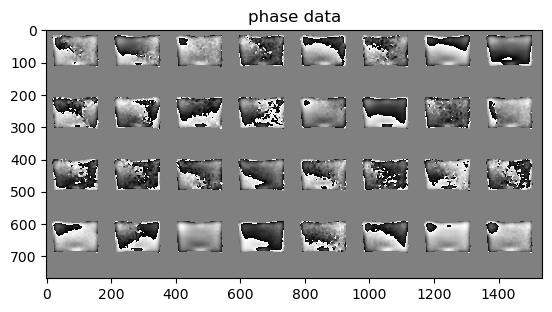

PyObject Text(0.5, 1.0, 'phase data')

In [13]:
# show some results
showThisSlice = 3;
figure(1); 
imal(abs.(coil_s_profiles[:,:,showThisSlice,:]).*repeat(mask[:,:,showThisSlice],1,1,coildim),8,4); title("before fitting")
figure(2);
imal(abs.(coil_s_profiles_fitted[:,:,showThisSlice,:]).*repeat(mask[:,:,showThisSlice],1,1,coildim),8,4); title("fitted data")
figure(3);
imal(angle.(coil_s_profiles_fitted[:,:,showThisSlice,:]).*repeat(mask[:,:,showThisSlice],1,1,coildim),8,4); title("phase data")

In [14]:
function muse_general_loop(k,sensitivity_profiles,phasemap,excludeshots)

    i = complex(0,1);

    xdim,ydim,coiln = size(k);
    ns2 = size(phasemap,3);
    ns = div(ns2,2);

    includeshots = setdiff(1:ns2, excludeshots);
    ns2inc = length(includeshots);

    phaselist = zeros(ns2,ns2);
    for ecount = 1:ns2
        phasevaluetmp=(pi*(ecount-1)/ns)*collect(0:ns2-1);
        phaselist[ecount,:]=phasevaluetmp;
    end
    phaselist = exp.(i.*phaselist);

    subdata = zeros(ComplexF64,xdim,ydim,coiln,ns2inc);
    for cnt = 1:ns2inc
        shotnum = includeshots[cnt];
        tmp = k*0;
        tmp[:,shotnum:ns2:end,:] = k[:,shotnum:ns2:end,:];
        subdata[:,:,:,cnt]=qft(tmp);
    end

    PDMAPsingle = zeros(ComplexF64,xdim,ydim);
    mat2 = zeros(ComplexF64,coiln*ns2inc,ns2);
    phasemap = permutedims(phasemap,(2,3,1));
    sensitivity_profiles = permutedims(sensitivity_profiles,(2,3,1));

    for cntx = 1:xdim
        PDMAPsinglepre = zeros(ComplexF64,1,ydim);
        for cnty = 1:div(ydim,ns2)

            mat0 = subdata[cntx,cnty,:,:];
            mat1 = mat0[:];

            for cnt01 = 1:ns2inc
                shotnum = includeshots[cnt01];
                for cnt02 = 1:ns2
                    mat2[(coiln*(cnt01-1)+1):coiln*cnt01,cnt02]=phaselist[shotnum,cnt02]*(sensitivity_profiles[cnty+((cnt02-1)*div(ydim,ns2)),:,cntx]*phasemap[cnty+((cnt02-1)*div(ydim,ns2)),shotnum,cntx]);            
                end
            end

            mat3 = mat2\mat1;

            PDMAPsinglepre[1,cnty+(0*div(ydim,ns2)):div(ydim,ns2):cnty+((ns2-1)*div(ydim,ns2))]=mat3;

        end
        PDMAPsingle[cntx,:]=PDMAPsinglepre;
    end
    return PDMAPsingle
end;


884736884736

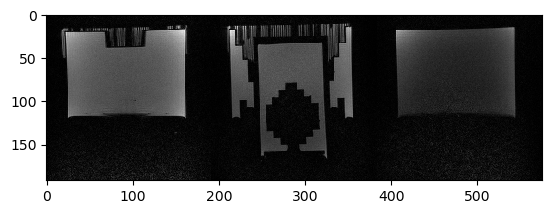

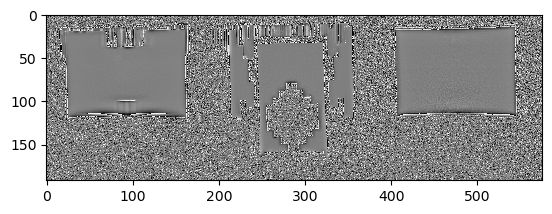

In [15]:
phasemap = ones(ComplexF64,xdim,ydim,2);
excludeshots = [];
recon_images = ones(ComplexF64,xdim,ydim,zdim);
for choose_this_slice = 1: zdim
    ktmp = k[:,:,choose_this_slice,:];
    recon_images[:,:,choose_this_slice]= muse_general_loop(ktmp,coil_s_profiles_fitted[:,:,choose_this_slice,:],phasemap,excludeshots);
end
figure(1); imal(abs.(recon_images),3,1);
figure(2); imal(angle.(recon_images),3,1);

### using only coils with sufficient signals & restore background phase

In [16]:
coil_s_profiles_masked = coil_s_profiles_fitted .* repeat(mask,1,1,1,coildim);

abs_coil_s_profiles_masked = abs.(coil_s_profiles_masked);
maxvalue = maximum(abs_coil_s_profiles_masked[:]);

abs_coil_s_profiles_masked_thresholded = abs_coil_s_profiles_masked .> 0.2*maxvalue;
tmp1 = reshape(abs_coil_s_profiles_masked_thresholded,(xdim*ydim,zdim,coildim));
tmp2 = sum(tmp1,dims=1);
tmp3 = (tmp2.>10); 
choose_channels= tmp3[1,:,:];
@show choose_channels[3,:];

choose_channels[3, :] = Bool[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]


884736884736

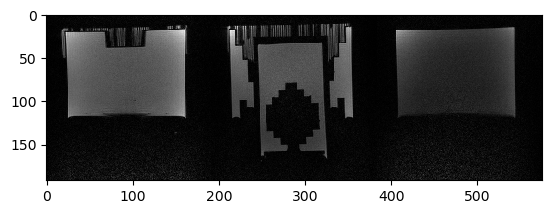

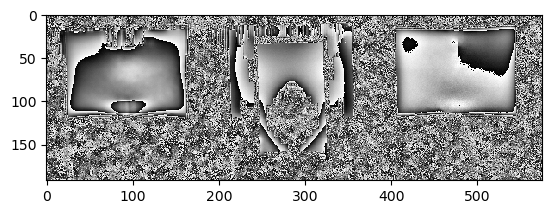

In [31]:

phase_term = zeros(xdim,ydim,zdim);
for cnt = 1: zdim
    tmp1 = choose_channels[cnt,:];
    tmp2 = findall(tmp1 .>0);
    tmp3 = data_smoothed[:,:,cnt,tmp2];
    tmp4 = sum(tmp3,dims=3);
    phase_term[:,:,cnt]= angle.(tmp4);
end

normalization_factor = repeat(exp.(-i.*phase_term),1,1,1,coildim);
coil_s_profiles_fitted_normalized = coil_s_profiles_fitted .* normalization_factor;

recon_images_ver2 = ones(ComplexF64,xdim,ydim,zdim);
for choose_this_slice = 1: zdim
    choose_channels_slice = findall(choose_channels[choose_this_slice,:].==1);
    ktmp = k[:,:,choose_this_slice,choose_channels_slice];
    recon_images_ver2[:,:,choose_this_slice]= muse_general_loop(ktmp,coil_s_profiles_fitted_normalized[:,:,choose_this_slice,choose_channels_slice],phasemap,excludeshots);
end
figure(1); imal(abs.(recon_images_ver2),3,1);
figure(2); imal(angle.(recon_images_ver2),3,1);

1769472

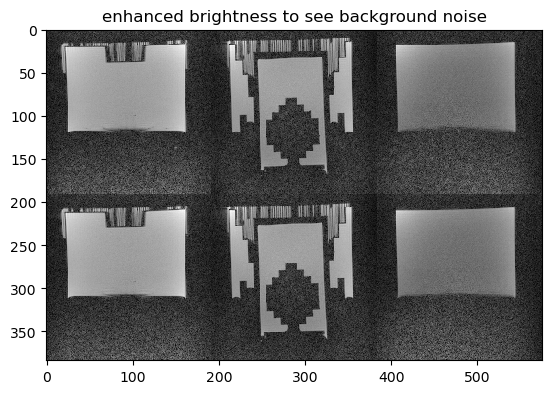

In [32]:
figure(1); imal([abs.(recon_images); abs.(recon_images_ver2)].^0.4,3,1);
title("enhanced brightness to see background noise");